# 欧拉算法

在本教程中，我们将探索欧拉算法及其在 NetworkX 中的实现，位于 [`networkx/algorithms/euler.py`](https://github.com/networkx/networkx/blob/main/networkx/algorithms/euler.py)。

## 导入包

In [1]:
import networkx as nx

## 哥尼斯堡七桥问题

下面展示的是美丽的哥尼斯堡老城区，以其七座桥梁而闻名。这些桥梁要么连接两个大岛屿——克奈福和洛姆塞，要么连接城市的两个大陆部分。

![image:map](images/map.png)

这座城镇之所以闻名，是因为大约300年前，数学家莱昂哈德·欧拉被问到了这样一个问题 [^1]：

> ***你能否在哥尼斯堡散步，通过每座桥梁一次且仅一次来访问每个区域？***

欧拉对这个问题的否定解答奠定了图论的基础。在深入探讨欧拉的解决方案之前，让我们先重新表述这个问题。

### 用抽象术语重新表述问题

为了更清晰地观察，我们首先应该简化一下地图。

![image:part1](images/part1.png)

欧拉观察到，在每个陆地区域内选择路线是无关紧要的。唯一重要的是要跨越的桥梁的顺序。这一观察使我们能够进一步抽象问题。在下图中，蓝色顶点代表陆地区域，边代表连接它们的桥梁。

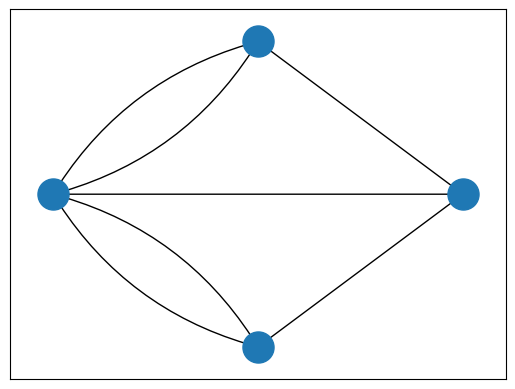

In [2]:
# 创建图
G = nx.DiGraph()
G.add_edge("A", "B", label="a")
G.add_edge("B", "A", label="b")
G.add_edge("A", "C", label="c")
G.add_edge("C", "A", label="d")
G.add_edge("A", "D", label="e")
G.add_edge("B", "D", label="f")
G.add_edge("C", "D", label="g")

positions = {"A": (0, 0), "B": (1, -2), "C": (1, 2), "D": (2, 0)}

# 可视化图
nx.draw_networkx_nodes(G, pos=positions, node_size=500)
nx.draw_networkx_edges(
    G, pos=positions, edgelist=[("A", "D"), ("B", "D"), ("C", "D")], arrowstyle="-"
)
nx.draw_networkx_edges(
    G,
    pos=positions,
    edgelist=[("A", "B"), ("B", "A"), ("C", "A"), ("A", "C")],
    arrowstyle="-",
    connectionstyle="arc3,rad=0.2",
);

基于这种抽象，我们可以将问题重新表述如下：

> ***你能否在不抬笔或多次经过同一条线的情况下画出上述图？***

如果你能做到，这意味着图中存在一个 ***欧拉路径***。如果这条路径起点和终点在同一个蓝色圆圈，则称为 ***欧拉回路***。

请注意，每个欧拉回路也是一个欧拉路径。

### 欧拉的方法

欧拉 [^2] 用大写字母 $A$、$B$、$C$ 和 $D$ 表示城镇的陆地区域，用小写字母 $a$、$b$、$c$、$d$、$e$、$f$ 和 $g$ 表示桥梁。让我们根据这些节点和边的标签绘制图。

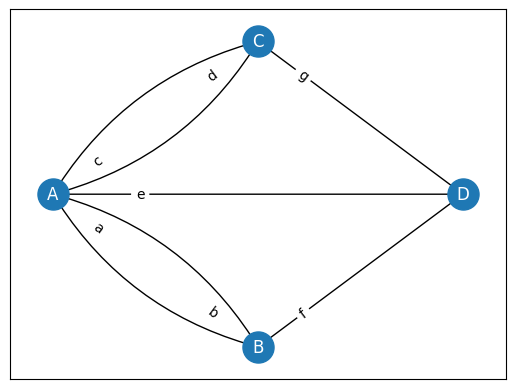

In [3]:
# 设计和绘制图
edge_labels = nx.get_edge_attributes(G, "label")

nx.draw_networkx_nodes(G, pos=positions, node_size=500)
nx.draw_networkx_labels(G, pos=positions, font_color="w")
nx.draw_networkx_edges(
    G, pos=positions, edgelist=[("A", "D"), ("B", "D"), ("C", "D")], arrowstyle="-"
)
nx.draw_networkx_edges(
    G,
    pos=positions,
    edgelist=[("A", "B"), ("B", "A"), ("C", "A"), ("A", "C")],
    arrowstyle="-",
    connectionstyle="arc3,rad=0.2",
)
nx.draw_networkx_edge_labels(G, pos=positions, edge_labels=edge_labels, label_pos=0.2);

他描述了他的逻辑如下：
- 如果我们跨越桥梁 $a$，我们从 $A$ 走到 $B$。在这种情况下，我们的旅行路线表示为 $AB$。
- 如果我们先跨越 $a$ 然后跨越 $f$，我们的路线将是 $ABD$。
- 因此，顺序使用 $n$ 座桥梁表示为 $n+1$ 个大写字母。
- 由于我们需要跨越每座桥梁，我们的路线应由长度为8的 $A$、$B$、$C$ 和 $D$ 的序列组成。

他还指出了每个陆地区域在路线中出现的次数取决于它拥有的桥梁数量这一事实。
- $A$ 有5座桥梁。这5座桥梁在我们的欧拉路径中应恰好出现一次。因此，$A$ 应在我们路线中出现3次。
- $B$ 有3座桥梁。它应在我们路线中出现2次。
- $C$ 有3座桥梁。它应在我们路线中出现2次。
- $D$ 有3座桥梁。它应在我们路线中出现2次。
- 那么，路线的总长度应为 3 + 2 + 2 + 2 = 9。

显然，我们无法同时满足这两个条件。因此，欧拉得出结论，哥尼斯堡七桥问题没有解决方案（即哥尼斯堡没有欧拉路径）。

### 推广欧拉的解决方案

欧拉将他应用于哥尼斯堡问题的方法推广如下：

> ***一个图有欧拉路径当且仅当度数为奇数的顶点数量为零或两个。***
- 如果存在两个度数为奇数的顶点，那么它们分别是起始顶点和结束顶点。
- 如果没有度数为奇数的顶点，任何顶点都可以作为起始或结束顶点，并且该图还具有欧拉回路。

## NetworkX 中的欧拉算法

NetworkX 实现了几种使用欧拉算法的方法。这些方法包括：
- **is_eulerian**      : 判断图是否具有欧拉回路
- **eulerian_circuit** : 图中的欧拉回路的边序列
- **eulerize**         : 将图转换为欧拉图
- **is_semieulerian**  : 判断图是否具有欧拉路径但不具有欧拉回路
- **has_eulerian_path** : 判断图是否具有欧拉路径
- **eulerian_path**    : 图中的欧拉路径的边序列

在这一部分，我们将简要解释 NetworkX 中欧拉算法的实现，通过解释其中的一些方法。

**注意**：NetworkX 的实现不允许具有孤立节点的图具有欧拉路径和/或欧拉回路。因此，欧拉路径或欧拉回路必须不仅访问所有边，还要访问图中的所有顶点。

### 1. 欧拉回路的实现

`is_eulerian` 方法的实现相当简单。为了具有欧拉回路（即成为欧拉图）：
- 有向图必须是强连通的，并且其每个顶点的入度和出度必须相等。
- 无向图必须是连通的，并且不能有度数为奇数的顶点。

以下是一个示例：

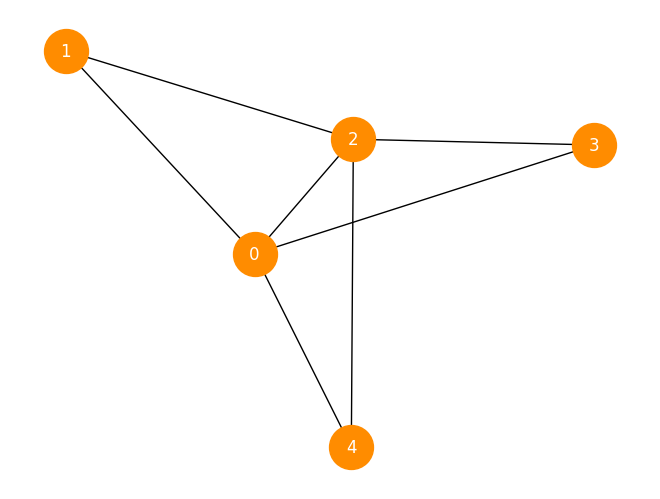

In [4]:
T = nx.Graph([(0, 1), (0, 2), (0, 3), (0, 4), (1, 2), (2, 3), (2, 4)])
nx.draw(
    T, with_labels=True, node_size=1000, font_color="White", node_color="darkorange"
)

In [5]:
def is_eulerian(G):
    if G.is_directed():
        return all(
            G.in_degree(n) == G.out_degree(n) for n in G
        ) and nx.is_strongly_connected(G)
    else:
        return all(d % 2 == 0 for v, d in G.degree()) and nx.is_connected(G)

In [6]:
is_eulerian(T)

True

NetworkX 还实现了 `eulerian_circuit` 方法来确定构成欧拉回路的边序列。

该方法使用堆栈数据结构来保存顶点，从源顶点开始并将其压入堆栈。在每次迭代中，它从堆栈中弹出一个顶点，选择其一个邻居，将选定的顶点压入堆栈，并从图中移除选定的边。

```python
circuit = []

if G.is_directed():
    degree = G.out_degree
    edges = G.out_edges
else:
    degree = G.degree
    edges = G.edges

vertex_stack = [0]
last_vertex = None
while vertex_stack:
    current_vertex = vertex_stack[-1]
    circuit.append(current_vertex)
    if G.degree(current_vertex) == 0:
        if last_vertex is not None:
            break
        last_vertex = current_vertex
        vertex_stack.pop()
    else:
        _, next_vertex = next(iter(G.edges(current_vertex)))
        vertex_stack.append(next_vertex)
        G.remove_edge(current_vertex, next_vertex)
```

### 2. 欧拉路径的实现

NetworkX 实现的 `has_eulerian_path` 首先检查图是否 `is_eulerian`。记住，如果一个图是欧拉图（即具有欧拉回路），那么它也具有欧拉路径。

```python
def has_eulerian_path(G, source=None):
    if nx.is_eulerian(G):
        return True
```

如果一个无向图不是欧拉图，它仍然可以是 `semi_eulerian`，这意味着它可能具有起点和终点不同的欧拉路径。如上所述，这只有在以下情况下才可能：
- 恰好有两个度数为奇数的顶点，并且
- 其所有顶点都属于单个连通分量。

如果用户提供了源顶点，它必须具有奇数度。否则，从给定的源顶点开始不可能有欧拉路径。

```python
    if G.is_directed() == False:
        if source is not None and G.degree[source] % 2 != 1:
            return False
        return(sum(d % 2 == 1 for _, d in G.degree()) == 2 and nx.is_connected(G))
```

对于有向图来说，要具有欧拉路径，它必须满足以下条件：
- 最多有一个顶点的出度 - 入度 = 1，
- 最多有一个顶点的入度 - 出度 = 1，
- 其他所有顶点的入度和出度相等，并且
- 其所有顶点都属于单个连通分量的底层无向图（即应该是弱连通的）。

```python
    if G.is_directed():
        ins = G.in_degree
        outs = G.out_degree
        if source is not None and outs[source] - ins[source] != 1:
            return False

        unbalanced_ins = 0
        unbalanced_outs = 0
        for v in G:
            if ins[v] - outs[v] == 1:
                unbalanced_ins += 1
            elif outs[v] - ins[v] == 1:
                unbalanced_outs += 1
            elif ins[v] != outs[v]:
                return False

        return (
            unbalanced_ins <= 1 and unbalanced_outs <= 1 and nx.is_weakly_connected(G)
        )
```
利用已实现的方法，```is_semieulerian``` 只需一行代码即可检查输入图是否没有欧拉回路但有欧拉路径。

In [7]:
def is_semieulerian(G):
    return has_eulerian_path(G) and not is_eulerian(G)

### 3. 示例

让我们在七桥问题上调用上述方法。基于前述原因，我们预期该图既没有欧拉回路也没有欧拉路径。

In [8]:
nx.is_eulerian(G)

False

In [9]:
nx.has_eulerian_path(G)

False

我们可以通过另一个例子来结束本节。你认为轮图会有欧拉路径吗？

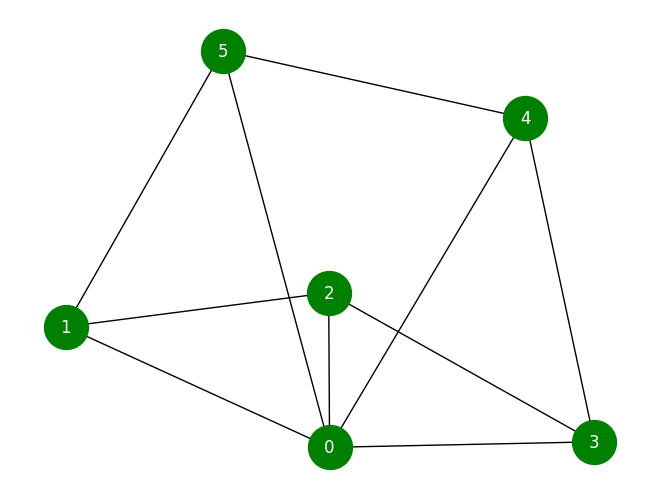

In [10]:
W = nx.wheel_graph(6)
nx.draw(W, with_labels=True, node_size=1000, font_color="White", node_color="green")

答案是否定的！除了中心的一个节点外，轮图中的所有节点都有恰好三条边。因此，它不可能有欧拉路径。

In [11]:
nx.has_eulerian_path(W)

False

## 欧拉无处不在！

欧拉算法对于使用路径的任何人或任何事物都至关重要。其现实应用的一些例子包括：
- 解决许多复杂问题，如上述的哥尼斯堡七桥问题。
- 邮递员可以利用欧拉路径规划一条无需重复走过的路线。
- 对画家、垃圾收集、飞行员、GPS开发者（例如谷歌地图开发者）等都非常有用。

## 参考文献

[^1]:  [Wikipedia, 哥尼斯堡七桥问题](https://en.wikipedia.org/wiki/Seven_Bridges_of_K%C3%B6nigsberg)

[^2]:  Euler, Leonhard, ‘Solutio problematis ad geometriam situs pertinentis’ (1741), Eneström 53, MAA Euler Archive.